# Klasifikasi Diagnosis Covid-19 Berdasarkan X-Ray Dengan CNN
Nama: R. Ferdian Dita Nugraha

NIM: 21/476963/PA/20622

## Import Modul

In [2]:
import os, re, time, json
import PIL.Image
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.10.1


## Set Parameter

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 100
IMG_WIDTH = 100
data_dir = "./dataset"

## Muat Dataset

### Undersampling
Karena jumlah data positif sangat sedikit, maka dilakukan undersampling untuk mengurangi jumlah data negatif.

In [4]:
negative_files_before = os.listdir(data_dir + "/negatif")
positive_files_before = os.listdir(data_dir + "/positif")

print("Negative files before: {}".format(len(negative_files_before)))
print("Positive files before: {}".format(len(positive_files_before)))

Negative files before: 4126
Positive files before: 3674


In [5]:
np.random.seed(42)

negative_to_keep = np.random.randint(3000, 5000)

new_negative_files = set(np.random.choice(os.listdir(data_dir + "/negatif"), size=negative_to_keep, replace=False))
for f in negative_files_before:
    if f not in new_negative_files:
        os.remove(data_dir + "/negatif/" + f)

In [6]:
negative_files_after = os.listdir(data_dir + "/negatif")
positive_files_after = os.listdir(data_dir + "/positif")

print("Negative files after: {}".format(len(negative_files_after)))
print("Positive files after: {}".format(len(positive_files_after)))

Negative files after: 4126
Positive files after: 3674


### Memecah dataset menjadi train, validation, dan test set

In [7]:
import splitfolders

splitfolders.ratio(data_dir, output=data_dir + "/split", seed=42, ratio=(.8, .1, .1), group_prefix=None, move=False)

train_dir = data_dir + "/split/train"
val_dir = data_dir + "/split/val"
test_dir = data_dir + "/split/test"

train_neg_dir = train_dir + "/negatif"
train_pos_dir = train_dir + "/positif"
val_neg_dir = val_dir + "/negatif"
val_pos_dir = val_dir + "/positif"
test_neg_dir = test_dir + "/negatif"
test_pos_dir = test_dir + "/positif"

total_train = len(os.listdir(train_neg_dir)) + len(os.listdir(train_pos_dir))
total_val = len(os.listdir(val_neg_dir)) + len(os.listdir(val_pos_dir))
total_test = len(os.listdir(test_neg_dir)) + len(os.listdir(test_pos_dir))

print("Total training negative images: {}".format(len(os.listdir(train_neg_dir))))
print("Total training positive images: {}".format(len(os.listdir(train_pos_dir))))
print("Total validation negative images: {}".format(len(os.listdir(val_neg_dir))))

print("Total validation positive images: {}".format(len(os.listdir(val_pos_dir))))
print("Total test negative images: {}".format(len(os.listdir(test_neg_dir))))
print("Total test positive images: {}".format(len(os.listdir(test_pos_dir))))

Copying files: 7800 files [00:55, 140.34 files/s]

Total training negative images: 3300
Total training positive images: 2939
Total validation negative images: 412
Total validation positive images: 367
Total test negative images: 414
Total test positive images: 368


### Membuat dataset

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    validation_split=0.2,
    rescale=1./255,
)

train_ds = train_datagen.flow_from_directory(
    data_dir + "/split/train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
)

test_ds = train_datagen.flow_from_directory(
    data_dir + "/split/test",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
)

val_ds = train_datagen.flow_from_directory(
    data_dir + "/split/train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=True,
)

Found 4992 images belonging to 3 classes.
Found 782 images belonging to 3 classes.
Found 1247 images belonging to 3 classes.


In [9]:
class_names = ["negatif", "positif"]

## Visualisasi Data

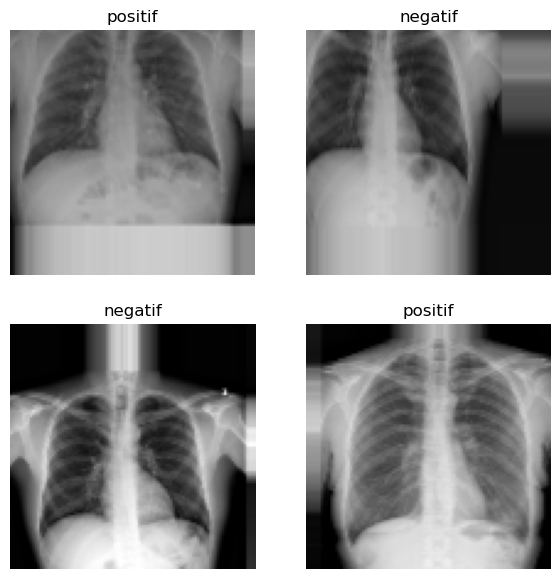

In [10]:
fig = plt.figure(figsize=(7, 7))
n = 4

for i in range(n):
    # randomly pick image
    index = np.random.randint(len(train_ds))
    image = train_ds[index][0][0]
    label = train_ds[index][1][0]

    ax = fig.add_subplot(2, n//2, i+1)
    plt.imshow(image)
    plt.title(class_names[int(label)])
    plt.axis("off")

plt.show()


## Modeling

### Melatih Model

In [11]:
EPOCHS = 15
steps_per_epoch = np.ceil(train_ds.samples / BATCH_SIZE)
val_steps_per_epoch = np.ceil(val_ds.samples / BATCH_SIZE)

In [12]:
model = tf.keras.Sequential([
    # block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=(3, 3)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    # block 2
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=(3, 3)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=(3, 3)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    # block 3
    tf.keras.layers.Conv2D(filters=128, padding='same', kernel_size=(3, 3)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(filters=128, padding='same', kernel_size=(3, 3)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    # fully connected layer
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),

    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-1, patience=5, verbose=1, min_delta=1e-4)

# compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# fit the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    verbose=1,
    batch_size=BATCH_SIZE,
    # steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    # validation_steps=val_steps_per_epoch,
    callbacks=[early]
)



Epoch 1/15
156/156 [==============================] - 105s 669ms/step - loss: 0.6365 - accuracy: 0.6314 - val_loss: 0.6086 - val_accuracy: 0.7233
Epoch 2/15
156/156 [==============================] - 84s 537ms/step - loss: 0.5281 - accuracy: 0.7430 - val_loss: 0.4751 - val_accuracy: 0.7803
Epoch 3/15
156/156 [==============================] - 82s 526ms/step - loss: 0.4733 - accuracy: 0.7812 - val_loss: 0.4238 - val_accuracy: 0.8148
Epoch 4/15
156/156 [==============================] - 81s 522ms/step - loss: 0.4292 - accuracy: 0.8069 - val_loss: 0.4237 - val_accuracy: 0.8083
Epoch 5/15
156/156 [==============================] - 84s 538ms/step - loss: 0.4124 - accuracy: 0.8191 - val_loss: 0.4729 - val_accuracy: 0.7939
Epoch 6/15
156/156 [==============================] - 84s 537ms/step - loss: 0.3851 - accuracy: 0.8285 - val_loss: 0.3997 - val_accuracy: 0.8356
Epoch 7/15
156/156 [==============================] - 82s 526ms/step - loss: 0.3683 - accuracy: 0.8361 - val_loss: 0.4086 - val_a

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                        

In [14]:
loss, accuracy = model.evaluate(val_ds, steps=val_steps_per_epoch)

39/39 [==============================] - 8s 195ms/step - loss: 0.2781 - accuracy: 0.8765


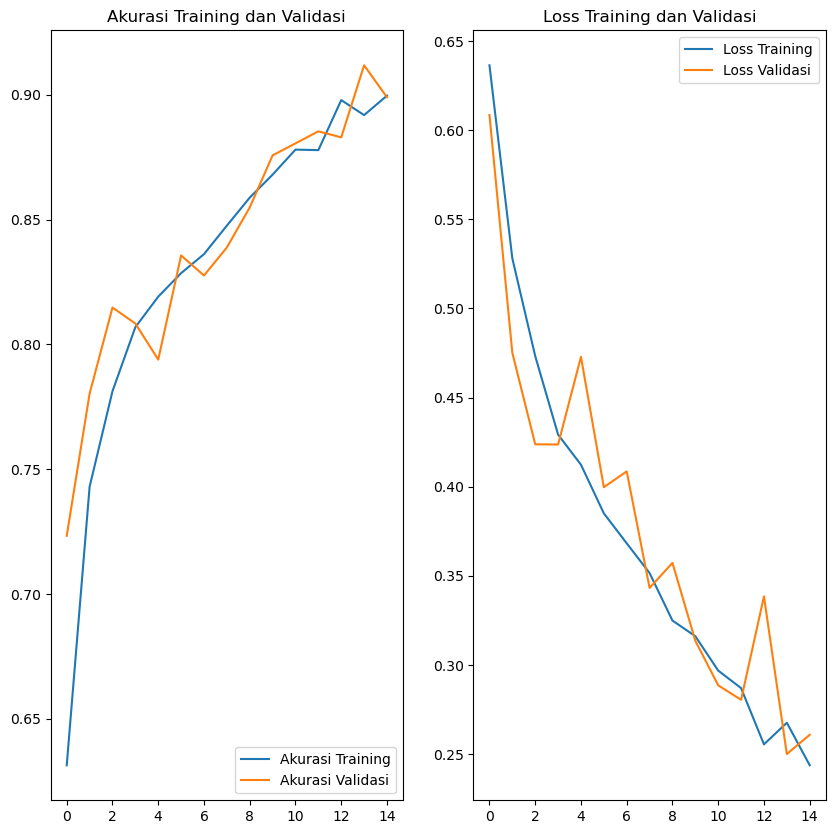

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label="Akurasi Training")
plt.plot(epochs_range, val_accuracy, label="Akurasi Validasi")
plt.legend(loc="lower right")
plt.title("Akurasi Training dan Validasi")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Loss Training")
plt.plot(epochs_range, val_loss, label="Loss Validasi")
plt.legend(loc="upper right")
plt.title("Loss Training dan Validasi")

plt.show()



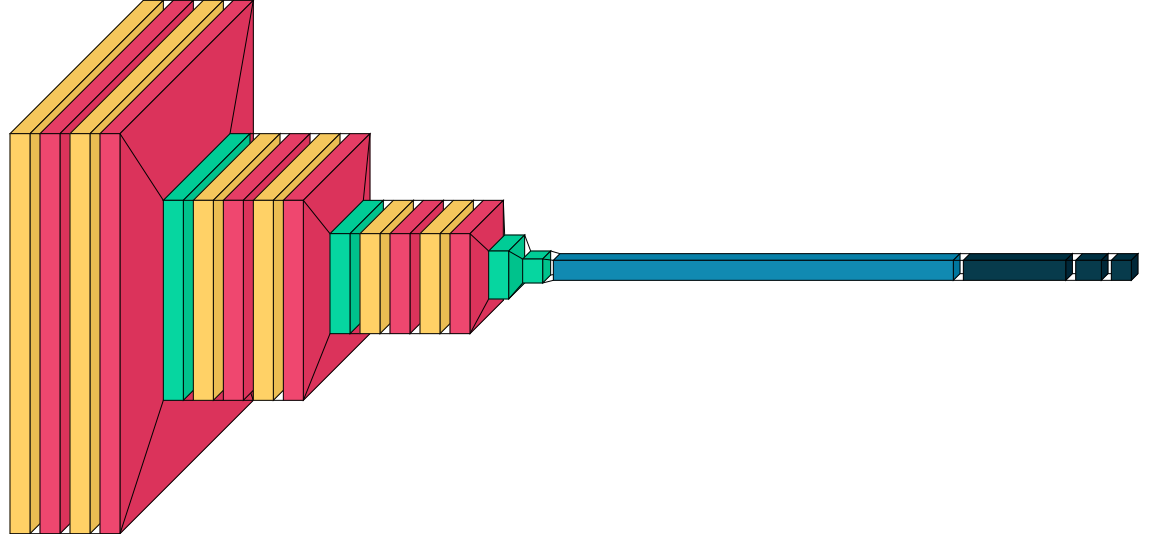

In [16]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)

visualkeras.layered_view(model, legend=True, font=font).show()
visualkeras.layered_view(model)

## Menampilkan Hasil Prediksi

In [17]:
# Menampilkan gambar dan hasil prediksi
def display_images_with_labels(images, predictions, labels, title):
    n = 10

    indexes = np.random.choice(len(predictions), size=n).astype('int32')
    n_images = images[indexes] * 255
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    fig = plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1)
        plt.xlabel(class_names[int(n_predictions[i])] + " (" + class_names[int(n_labels[i])] + ")")
        plt.xticks([])
        plt.yticks([])

        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color('red')

        plt.imshow(n_images[i].astype('uint8'))

In [18]:
# convert the dataset batches to numpy arrays
print("Converting the dataset to numpy arrays...")
test_images, test_labels = [], []
for i in range(train_ds.__len__()):
    images, labels = train_ds.next()
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

Converting the dataset to numpy arrays...


25/25 [==============================] - 4s 178ms/step


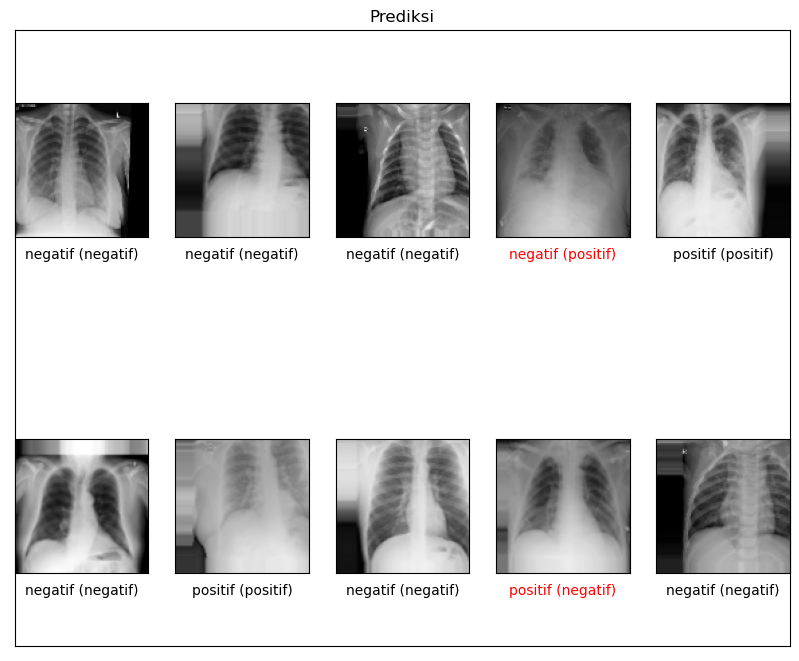

In [22]:
predicted_labels = (model.predict(test_ds) > 0.5).astype("int32")

# tampilkan hasil prediksi
display_images_with_labels(test_images, predicted_labels, test_labels, "Prediksi")